# HW02 Template

In [2]:

import numpy as np

def _as_col(vec):
    v = np.asarray(vec)
    if v.ndim == 1: return v.reshape(-1, 1)
    return v

def _check_shapes(data, labels):
    X = np.asarray(data, dtype=float)
    y = np.asarray(labels, dtype=float)
    if X.ndim != 2: raise ValueError("data must be 2D, shape (d, n)")
    if y.ndim == 1: y = y.reshape(1, -1)
    if y.shape[0] != 1: raise ValueError("labels must have shape (1, n)")
    if X.shape[1] != y.shape[1]: raise ValueError("n mismatch between data and labels")
    return X, np.sign(y)

def score(data, labels, th, th0):
    X, y = _check_shapes(data, labels)
    th = _as_col(th)
    th0 = float(np.asarray(th0).reshape(-1)[0])
    vals = (th.T @ X + th0).reshape(-1)
    preds = np.where(vals >= 0.0, 1.0, -1.0)
    return int(np.sum(preds == y.reshape(-1)))




def eval_classifier(learner, data_train, labels_train, data_test, labels_test, **learner_kwargs):
    th, th0 = learner(data_train, labels_train, **learner_kwargs)
    correct = score(data_test, labels_test, th, th0)
    return correct / data_test.shape[1]

def eval_learning_alg(learner, data_gen, n_train, n_test, it, **learner_kwargs):
    accs = []
    for _ in range(it):
        Xtr, ytr = data_gen(n_train)
        Xte, yte = data_gen(n_test)
        accs.append(eval_classifier(learner, Xtr, ytr, Xte, yte, **learner_kwargs))
    return float(np.mean(accs))

def kfold_cross_validation(learner, data, labels, k=5, shuffle=True, rng=None, **learner_kwargs):
    X, y = _check_shapes(data, labels)
    d, n = X.shape
    idx = np.arange(n)
    if shuffle:
        rng = np.random.default_rng() if rng is None else rng
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    accs = []
    for j in range(k):
        test_idx = folds[j]
        train_idx = np.hstack([folds[i] for i in range(k) if i != j])
        Xtr, ytr = X[:,train_idx], y[:,train_idx]
        Xte, yte = X[:,test_idx], y[:,test_idx]
        accs.append(eval_classifier(learner, Xtr, ytr, Xte, yte, **learner_kwargs))
    return float(np.mean(accs))

def gen_lin_separable(n, d=2, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    th_true = rng.normal(size=(d,1)); th_true /= np.linalg.norm(th_true)+1e-12
    X = rng.normal(size=(d,n))
    offsets = rng.uniform(1.0, 1.5, size=(1,n))*rng.choice([-1.0,1.0], size=(1,n))
    X = X + (th_true/(np.linalg.norm(th_true)+1e-12))*offsets
    y = np.where(th_true.T@X >= 0, 1.0, -1.0).reshape(1,-1)
    return X, y

def gen_flipped_lin_separable(n, d=2, pflip=0.1, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    X, y = gen_lin_separable(n, d=d, rng=rng)
    flips = rng.random(size=(1,n)) < pflip
    y = y*np.where(flips, -1.0, 1.0)
    return X, y


In [3]:

import numpy as np
import matplotlib.pyplot as plt



def plot_separator_2d(th, th0, X, y, title=None):
    if th.shape[0] != 2:
        return
    xs = np.linspace(X[0].min()-1, X[0].max()+1, 200)
    w0, w1 = th[0,0], th[1,0]
    if abs(w1) < 1e-12:
        return
    ys = -(w0*xs + float(np.asarray(th0).reshape(-1)[0])) / w1
    plt.scatter(X[0, y.flatten()==1],  X[1, y.flatten()==1],  marker='+', label='+1')
    plt.scatter(X[0, y.flatten()==-1], X[1, y.flatten()==-1], marker='o', label='-1')
    plt.plot(xs, ys, linewidth=2)
    if title: plt.title(title)
    plt.legend()

def make_hook_for_dataset(X, y, capture_list):
    def _hook(params):
        th, th0 = params
        capture_list.append((th.copy(), th0.copy()))
    return _hook


## Part 1

updates=12



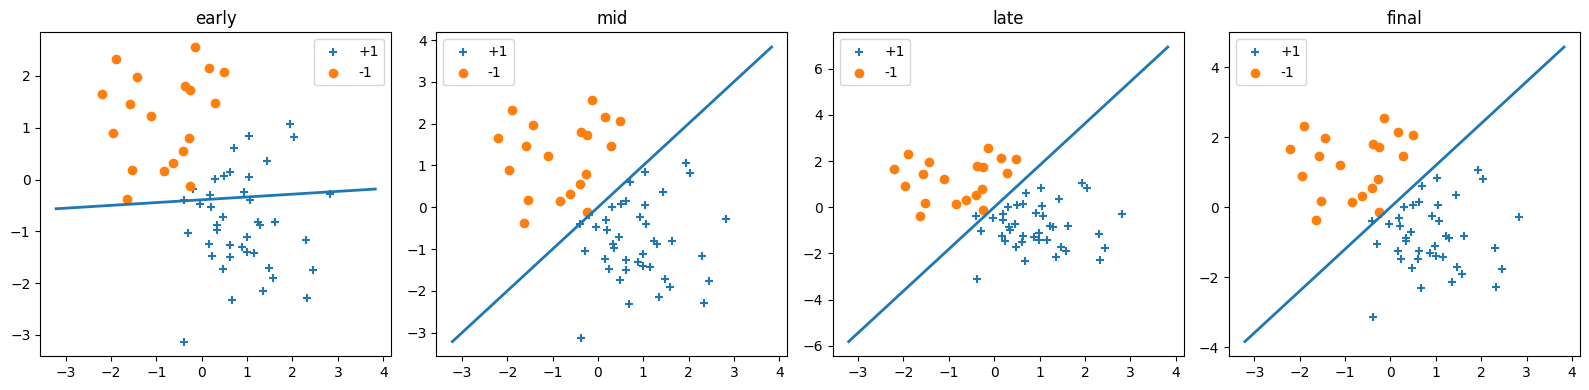

In [109]:


def perceptron(data, labels, T=1, hook=None):
    X, y = _check_shapes(data, labels)
    d, n = X.shape
    th = np.zeros((d,1)); th0 = 0.0

    # Regular perceptron
    for _ in range(T):
        for i in range(n):
            if y[0,i]*(th.T @ X[:,i].reshape(-1,1) + th0) <= 0:
                th += y[0,i] * X[:,i].reshape(-1,1)
                th0 += y[0,i]
                
                # If hook is provided, call it
                if hook is not None: hook((th, th0))

    return th, np.array([th0])




seed = 0; T = 5; n = 60; d = 2
rng = np.random.default_rng(seed)
X, y = gen_lin_separable(n, d=d, rng=rng)
capture = []; hook = make_hook_for_dataset(X, y, capture)
th, th0 = perceptron(X, y, T=T, hook=hook)


frames = [0, max(0,len(capture)//3-1), max(0,2*len(capture)//3-1), max(0,len(capture)-1)]
fig, axes = plt.subplots(1,4, figsize=(16,4))
for ax, idx, lab in zip(axes, frames, ["early","mid","late","final"]):
    plt.sca(ax); plot_separator_2d(*capture[idx], X, y, lab)
plt.tight_layout();

print(f"updates={len(capture)}\n")


## Part 2

Perceptron accuracy: 0.967
Averaged perceptron accuracy: 0.983


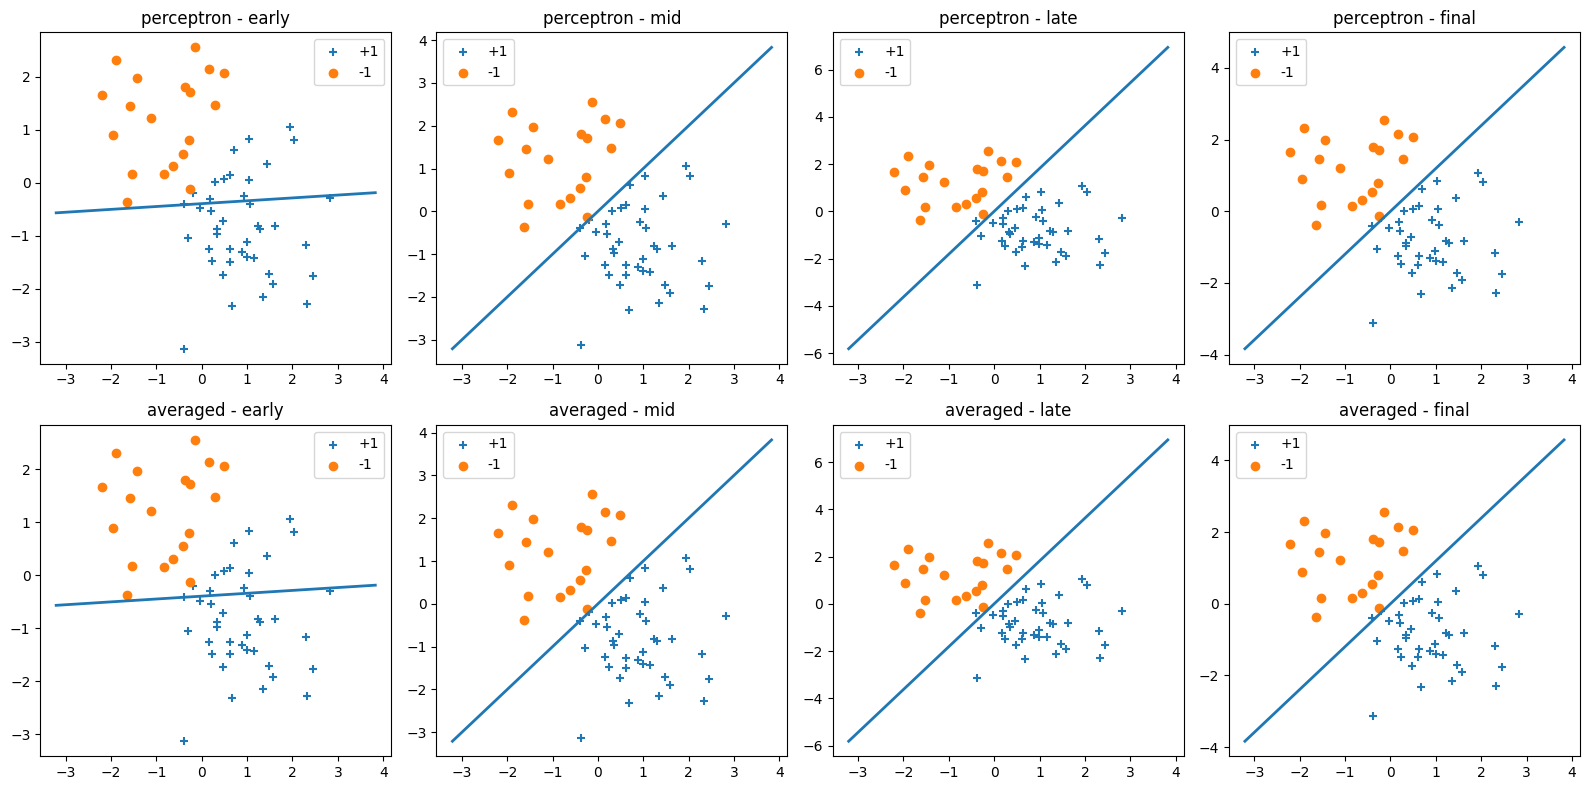

In [110]:
def averaged_perceptron(data, labels, T=1, hook=None):
    X, y = _check_shapes(data, labels)
    d, n = X.shape
    th = np.zeros((d,1)); th0 = 0.0
    ths = np.zeros_like(th); th0s = 0.0
    steps = n*T

    # Averaged perceptron
    for _ in range(T):
        for i in range(n):
            if y[0,i]*(th.T @ X[:,i].reshape(-1,1) + th0) <= 0:
                th += y[0,i] * X[:,i].reshape(-1,1)
                th0 += y[0,i]
                
                # If hook is provided, call it
                if hook is not None: hook((th, th0))
            
            # Accumulate parameters
            ths += th
            th0s += th0

    return ths/steps, np.array([th0s/steps])

seed = 0; T = 5; n = 60; d = 2
rng = np.random.default_rng(seed)
X, y = gen_lin_separable(n, d=d, rng=rng)

cap_p = []; hook_p = make_hook_for_dataset(X, y, cap_p)
th_p, th0_p = perceptron(X, y, T=T, hook=hook_p)

cap_ap = []; hook_ap = make_hook_for_dataset(X, y, cap_ap)
th_ap, th0_ap = averaged_perceptron(X, y, T=T, hook=hook_ap)



def pick(cap): return [cap[0], cap[max(0,len(cap)//3-1)], cap[max(0,2*len(cap)//3-1)], cap[-1]]
fp, fa = pick(cap_p), pick(cap_ap)
fig, axes = plt.subplots(2,4, figsize=(16,8))
for col, lab in enumerate(["early","mid","late","final"]):
    plt.sca(axes[0,col]); plot_separator_2d(*fp[col], X, y, f"perceptron - {lab}")
    plt.sca(axes[1,col]); plot_separator_2d(*fa[col], X, y, f"averaged - {lab}")
plt.tight_layout();

acc_p  = eval_classifier(perceptron, X, y, X, y, T=T)
acc_ap = eval_classifier(averaged_perceptron, X, y, X, y, T=T)


print(f"Perceptron accuracy: {acc_p:.3f}")
print(f"Averaged perceptron accuracy: {acc_ap:.3f}")


## Part 3

In [111]:

seed = 2; rng = np.random.default_rng(seed)
Xtr, ytr = gen_flipped_lin_separable(40, d=2, pflip=0.15, rng=rng)
Xte, yte = gen_flipped_lin_separable(40, d=2, pflip=0.15, rng=rng)
acc_p  = eval_classifier(perceptron, Xtr, ytr, Xte, yte, T=10)
acc_ap = eval_classifier(averaged_perceptron, Xtr, ytr, Xte, yte, T=10)


print(f"Perceptron accuracy: {acc_p:.3f}")
print(f"Averaged Perceptron accuracy: {acc_ap:.3f}")

Perceptron accuracy: 0.325
Averaged Perceptron accuracy: 0.500


## Part 4

In [112]:

seed = 3; rng = np.random.default_rng(seed)
data_gen = lambda m: gen_flipped_lin_separable(m, d=2, pflip=0.15, rng=rng)
avg_p  = eval_learning_alg(perceptron, data_gen, n_train=20, n_test=20, it=100, T=10)
avg_ap = eval_learning_alg(averaged_perceptron, data_gen, n_train=20, n_test=20, it=100, T=10)

print(f"Perceptron mean accuracy: {avg_p:.3f}")
print(f"Averaged Perceptron mean accuracy: {avg_ap:.3f}")

Perceptron mean accuracy: 0.507
Averaged Perceptron mean accuracy: 0.517


## Part 5

In [113]:

seed = 4; rng = np.random.default_rng(seed)
X, y = gen_flipped_lin_separable(80, d=2, pflip=0.20, rng=rng)
idx = np.arange(X.shape[1]); rng.shuffle(idx)
Xtr, ytr = X[:, idx[:60]], y[:, idx[:60]]
Xte, yte = X[:, idx[60:]], y[:, idx[60:]]
split_p  = eval_classifier(perceptron, Xtr, ytr, Xte, yte, T=10)
split_ap = eval_classifier(averaged_perceptron, Xtr, ytr, Xte, yte, T=10)
cv_p  = kfold_cross_validation(perceptron, X, y, k=5, shuffle=True, rng=rng, T=10)
cv_ap = kfold_cross_validation(averaged_perceptron, X, y, k=5, shuffle=True, rng=rng, T=10)


print(f"Perceptron single_split accuracy: {split_p:.3f}")
print(f"Averaged Perceptron single_split accuracy: {split_ap:.3f}")
print(f"Perceptron 5_fold_CV accuracy: {cv_p:.3f}")
print(f"Averaged Perceptron 5_fold_CV accuracy: {cv_ap:.3f}")

Perceptron single_split accuracy: 0.650
Averaged Perceptron single_split accuracy: 0.600
Perceptron 5_fold_CV accuracy: 0.438
Averaged Perceptron 5_fold_CV accuracy: 0.775


## Part 6

In [115]:
import pandas as pd

seed = 5; rng = np.random.default_rng(seed)

rows = []
for pflip in [0.00, 0.05, 0.10, 0.20, 0.30]:
    data_gen = (lambda m, p=pflip: gen_flipped_lin_separable(m, d=2, pflip=p, rng=rng))
    avg_p  = eval_learning_alg(perceptron, data_gen, n_train=20, n_test=20, it=120, T=10)
    avg_ap = eval_learning_alg(averaged_perceptron, data_gen, n_train=20, n_test=20, it=120, T=10)
    rows.append({"pflip": pflip, "perceptron": round(avg_p, 3), "averaged": round(avg_ap, 3)})

df = pd.DataFrame(rows)
display(df)  # show as a table

mask = (df["pflip"] >= 0.10) & (df["pflip"] <= 0.30)
mean_p  = df.loc[mask, "perceptron"].mean()
mean_ap = df.loc[mask, "averaged"].mean()
recommended = "Averaged perceptron" if mean_ap >= mean_p else "Perceptron"
print(f"Recommendation for 0.10 ≤ pflip ≤ 0.30 based on table: {recommended}")


,pflip,perceptron,averaged
0,0.00,0.468,0.493
1,0.05,0.512,0.452
2,0.10,0.504,0.480
3,0.20,0.535,0.473
4,0.30,0.484,0.484


Recommendation for 0.10 ≤ pflip ≤ 0.30 based on table: Perceptron
